In [4]:
import os
os.environ['OMP_NUM_THREADS'] = '16'

In [5]:
import pennylane as qml


from pennylane import numpy as np
from pennylane.templates import RandomLayers
import torch

import matplotlib.pyplot as plt

# Setting of the main hyper-parameters of the model


In [6]:
n_epochs = 30   # Number of optimization epochs
n_layers = 5    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 50     # Size of the test dataset

SAVE_PATH = "/content/"  # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
torch.manual_seed(0)       # Seed for TensorFlow random number generator

# Loading of the MNIST dataset


In [22]:
import torchvision
def transform(x):
    x = np.array(x)
    x = x/255.0
    
    return torch.from_numpy(x).float()
train_set = torchvision.datasets.MNIST(root='./mnist', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root='./mnist', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=2)
# print(len(train_loader))

# Quantum circuit as a convolution kernel

We follow the scheme described in the introduction and represented in
the figure at the top of this demo.

We initialize a PennyLane `default.qubit` device, simulating a system of
$4$ qubits. The associated `qnode` represents the quantum circuit
consisting of:

1.  an embedding layer of local $R_y$ rotations (with angles scaled by a
    factor of $\pi$);
2.  a random circuit of `n_layers`;
3.  a final measurement in the computational basis, estimating $4$
    expectation values.


[[5.30467815 5.3906313  5.32343968 3.91796626]
 [2.4151415  1.86946507 0.35633815 1.71315002]
 [3.00125845 5.10300662 3.01578552 2.46793966]
 [5.2532378  2.1199226  4.07258398 2.31372983]
 [6.01398323 0.88184996 5.46691948 2.97576711]]


/home/paultran27/miniconda3/envs/pnl/lib/python3.11/site-packages/pennylane/math/utils.py:228: UserWarning: Contains tensors of types {'autograd', 'torch'}; dispatch will prioritize TensorFlow, PyTorch, and Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


(<Figure size 2100x500 with 1 Axes>, <Axes: >)


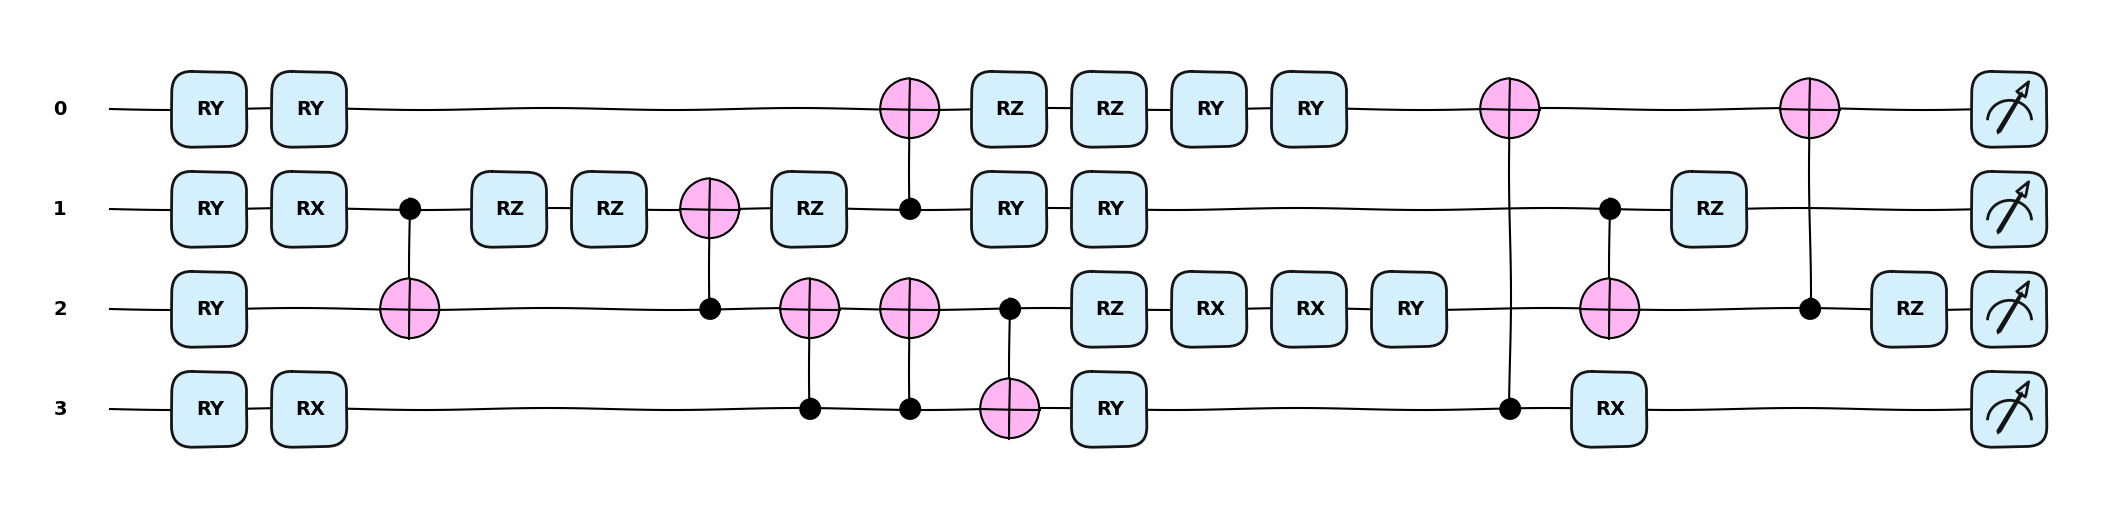

In [8]:
dev1 = qml.device("lightning.qubit", wires = 4)
dev2 = qml.device("default.qubit", wires = 4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

print(rand_params)
@qml.qnode(dev1, interface='torch', diff_method='adjoint')
def circuit1(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)), seed = None)


    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]


print(qml.draw_mpl(circuit1, level=None, style = 'pennylane_sketch')(torch.tensor([1,2,3,4]).cuda()))


In [9]:
import torch
from torch import nn 
class QuanvolutionLayerTest(nn.Module):
    def __init__(self, kernel_size=(2, 2), stride=1, n_filters=1, filter_layers = 1):
        super().__init__()
        self.kernel_size = kernel_size
        self.n_filters = n_filters
        self.num_wires = kernel_size[0] * kernel_size[1]
        self.filter_layer_size = np.random.randint(4, 2*self.num_wires*torch.floor(torch.log2(torch.tensor(self.num_wires))))
        print(self.filter_layer_size)
        
        self.total_wires = self.n_filters * self.num_wires
        self.filter_seeds = torch.randint(0, int(1e8), (1,)).item()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        # self.q_params = nn.Parameter(torch.randn(n_filters*filter_layers*self.filter_layer_size))
        self.n_rotations_gate = filter_layers*self.filter_layer_size
        self.kernel_h, self.kernel_w = self.kernel_size
        self.stride = stride
        
        dev = qml.device("lightning.qubit", wires=self.total_wires)
        @qml.qnode(dev,interface='torch', diff_method='best')
        def circuit(inputs, weights):
            # Encoding classical inputs
            qml.AngleEmbedding(inputs, wires=list(range(0, self.total_wires)), rotation="Y")
        
            # Add random quantum layers
            for i in range(self.n_filters):
                # print("WIRE RANGE: ", i*self.num_wires, i*self.num_wires + self.num_wires, weights[i*self.num_wires: i*self.num_wires + self.num_wires])
                RandomLayers(weights[:,i*self.n_rotations_gate: i*self.n_rotations_gate + self.n_rotations_gate], 
                            wires=list(range(i*self.num_wires, i*self.num_wires + self.num_wires)),
                            # rotations=[qml.PauliX,qml.PauliY,qml.PauliZ],
                            seed = self.filter_seeds+i)
                         
        
            # Measurement producing classical outputs
            measurement = [qml.expval(qml.PauliZ(j)) for j in range(self.total_wires)]
            # measurement = [sum(measurement[i*self.num_wires: i*self.num_wires + self.num_wires]) for i in range(self.n_filters)]
            return measurement
        
        weight_shapes = {"weights": (1,n_filters*filter_layers*self.filter_layer_size)}

        self.kernel_circuits = qml.qnn.TorchLayer(circuit, weight_shapes = weight_shapes).to(self.device)
        # print(qml.draw(self.kernel_circuits, level = None, decimals = 3)(torch.zeros(self.total_wires)))
    def forward(self, x):
        """
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, channels, height, width)

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, n_filters, new_height, new_width)
        """
        batch_size, channels, height, width = x.shape
        new_height = (height - self.kernel_h) // self.stride + 1
        new_width = (width - self.kernel_w) // self.stride + 1
        epsilon = 1e-8
        print(new_height, new_width)
        # Prepare output tensor
        output = torch.zeros((batch_size, self.n_filters, new_height, new_width), dtype=torch.float32).to(self.device)
        
        
        
        for b in range(batch_size):
            print("CUR BATCH: " + str(b))
            for i in range(0, height - self.kernel_h + 1, self.stride):  # Step by stride
                for j in range(0, width - self.kernel_w + 1, self.stride):  # Step by stride
                    if i + self.kernel_h <= height and j + self.kernel_w <= width:
                        q_out = torch.zeros(self.n_filters, dtype=torch.float32).to(self.device)
                        for c in range(channels):
                            kernel = x[b, c, i:i + self.kernel_h, j:j + self.kernel_w].flatten()
                            # print("kernel: ",kernel.size())
                            kernel = kernel[:self.num_wires]  # Adjust to fit the number of qubits
                            kernel = kernel / torch.max(torch.abs(kernel) + epsilon)  # Normalize
                            kernel = kernel.repeat(self.n_filters)
                            # quantum_output = torch.hstack(
                                
                            # )
                            quantum_output = torch.hstack([torch.sum(self.kernel_circuits(kernel)[i*self.num_wires: i*self.num_wires + self.num_wires]) for i in range(self.n_filters)])
                            q_out += quantum_output
                            # print(quantum_output, q_out)
                            # print(qml.draw(self.kernel_circuits, level = None)(kernel))
                        # break
                        output[b, :, i // self.stride, j // self.stride] = q_out  # Update with stride indexing
                        # print(output)

        return output

In [14]:
model = torch.nn.Sequential(
        QuanvolutionLayerTest(kernel_size=(2, 2), n_filters=3),
        # torch.nn.Flatten(),
        # torch.nn.Linear(in_features=588, out_features=10)
    )
outputs = model(imag.unsqueeze(1).cuda())
print("Model output:",  outputs.size())
print(model._modules['0'].kernel_circuits.weights)

# qml.draw_mpl(model._modules['0'].kernel_circuits)(imag.unsqueeze(1))

7
27 27
CUR BATCH: 0
CUR BATCH: 1
CUR BATCH: 2
CUR BATCH: 3
Model output: torch.Size([4, 3, 27, 27])
Parameter containing:
tensor([[5.7503, 2.4951, 5.4925, 2.6352, 3.4740, 5.9862, 0.2272, 1.1638, 2.3463,
         1.9170, 5.8559, 1.1053, 1.6954, 0.9467, 0.1993, 1.3077, 5.8421, 4.5434,
         4.6642, 3.3068, 1.5309]], device='cuda:0', requires_grad=True)


In [17]:
print(model._modules['0'].kernel_circuits.weights.grad)

None


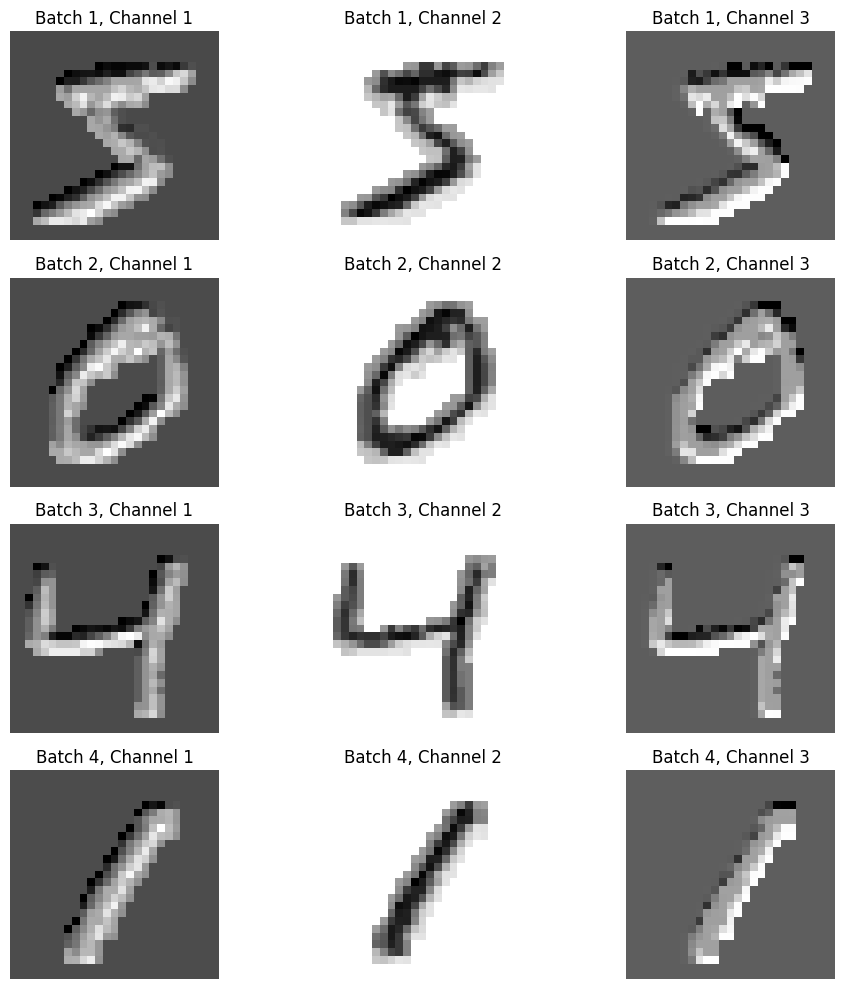

In [18]:
import torch
import matplotlib.pyplot as plt

# Generate a random tensor to simulate the model output
model_output = outputs  # Simulating a batch of 4 images with 3 channels and 27x27 size

# Set up the figure
fig, axes = plt.subplots(4, 3, figsize=(10, 10))

# Loop through the images in the batch and display them
for batch_idx in range(4):
    for channel_idx in range(3):
        ax = axes[batch_idx, channel_idx]
        ax.imshow(model_output[batch_idx, channel_idx].cpu().detach().numpy(), cmap = 'gray')
        ax.axis('off')  # Turn off axis
        ax.set_title(f"Batch {batch_idx+1}, Channel {channel_idx+1}")

# Adjust layout
plt.tight_layout()
plt.show()


In [13]:
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn


class QuanvolutionLayer(nn.Module):
    def __init__(self, kernel_size=(2, 2), stride=1, n_filters=1, filter_layers = 1):
        super().__init__()
        self.kernel_size = kernel_size
        self.n_filters = n_filters
        self.num_wires = kernel_size[0] * kernel_size[1]
        self.filter_layer_size = np.random.randint(4, 2*self.num_wires*torch.floor(torch.log2(torch.tensor(self.num_wires))))
        print(self.filter_layer_size)
        self.filter_seeds = [
            torch.randint(0, int(1e8), (1,)).item() for _ in range(self.n_filters)
        ]
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.q_params = nn.Parameter(torch.randn(n_filters , filter_layers*self.filter_layer_size))
        self.n_rotations_gate = filter_layers*self.filter_layer_size
        self.kernel_h, self.kernel_w = self.kernel_size
        self.stride = stride
    def forward(self, x):
        """
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, channels, height, width)

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, n_filters, new_height, new_width)
        """
        batch_size, channels, height, width = x.shape
        new_height = (height - self.kernel_h) // self.stride + 1
        new_width = (width - self.kernel_w) // self.stride + 1
        epsilon = 1e-8
        print(new_height, new_width)
        # Prepare output tensor
        output = torch.zeros((batch_size, self.n_filters, new_height, new_width), dtype=torch.float32).to(self.device)
        
        dev = qml.device("lightning.qubit", wires=self.num_wires)
        @qml.qnode(dev,interface='torch', diff_method='adjoint')
        def circuit(inputs, weights, seed = None):
            # Encoding classical inputs
            for j in range(self.num_wires):
                qml.RY(np.pi * inputs[j], wires=j)
        
            # Add random quantum layers
            RandomLayers(weights, 
                         wires=list(range(self.num_wires)),
                         # rotations=[qml.PauliX,qml.PauliY,qml.PauliZ],
                         seed = seed)
                         
        
            # Measurement producing classical outputs
            return [qml.expval(qml.PauliZ(j)) for j in range(self.num_wires)]
        
        for b in range(batch_size):
            print("CUR BATCH: " + str(b))
            for i in range(0, height - self.kernel_h + 1, self.stride):  # Step by stride
                for j in range(0, width - self.kernel_w + 1, self.stride):  # Step by stride
                    if i + self.kernel_h <= height and j + self.kernel_w <= width:
                        q_out = torch.zeros(self.n_filters, dtype=torch.float32).to(self.device)
                        for c in range(channels):
                            kernel = x[b, c, i:i + self.kernel_h, j:j + self.kernel_w].flatten()
                            # print("kernel: ",kernel.size())
                            kernel = kernel[:self.num_wires]  # Adjust to fit the number of qubits
                            kernel = kernel / torch.max(torch.abs(kernel) + epsilon)  # Normalize
                            for f in range(self.n_filters):
                                quantum_output = torch.sum(torch.hstack(
                                    circuit(inputs = kernel, weights = self.q_params[f].unsqueeze(0), seed = self.filter_seeds[f]))
                                ).float()

                                q_out[f] += quantum_output
                        output[b, :, i // self.stride, j // self.stride] = q_out  # Update with stride indexing
                        # print(output)

        return output

class DynLinear(nn.Module):
    def __init__(self, out_features):
        super().__init__()
        self.out_features = out_features
        self.linear = None  # Placeholder for the Linear layer

    def initialize_linear(self, in_features):
        """Dynamically initialize the Linear layer with the given input size."""
        self.linear = nn.Linear(in_features, self.out_features)
        nn.init.xavier_uniform_(self.linear.weight)
        self.linear.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

    def forward(self, x):
        if self.linear is None:
            # Initialize the Linear layer on the first forward pass
            in_features = x.shape[-1]
            self.initialize_linear(in_features)
        return self.linear(x)

# Example Neural Network with Quanvolutional Layer
class QuanvolutionalCNN(nn.Module):
    def __init__(self, model_type = "quantum"):
        super().__init__()
        
        if model_type == "classic":
            self.conv_block = nn.Sequential(
                nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
                nn.ReLU(),
                nn.BatchNorm2d(32),
                nn.MaxPool2d(2, 2),
                torch.nn.Dropout(0.5),
                nn.Conv2d(32, 32, 3),
                nn.ReLU(),
                nn.Conv2d(32, 64, 2),
                nn.ReLU(),
                nn.BatchNorm2d(64),
                nn.MaxPool2d(2, 2),
                torch.nn.Dropout(0.3)
            )
        elif model_type == 'quantum':
            self.conv_block = nn.Sequential(
                QuanvolutionLayerTest(kernel_size=(2,2), n_filters=3),
                nn.ReLU(),
                nn.BatchNorm2d(3),
                nn.MaxPool2d(2, 2),                
                torch.nn.Dropout(0.5),
                QuanvolutionLayerTest(kernel_size=(2,2), n_filters=2),
                nn.ReLU(),
                QuanvolutionLayerTest(kernel_size=(2,2), n_filters=4),
                nn.ReLU(),
                nn.BatchNorm2d(4),
                nn.MaxPool2d(2, 2),
                torch.nn.Dropout(0.3)
            )
        else:
            raise ValueError("Invalid model type. Choose either 'classic' or 'quantum'.")
        self.model_type = model_type
        # self.quanv = QuanvolutionLayer(kernel_size=(2, 2), n_filters=3)
        # self.conv  = nn.Conv2d(1, 32,(2,2))
        self.fc = nn.Sequential(
            DynLinear(256),  # Adjust based on quanv output shape
            torch.nn.Dropout(0.3),
            nn.ReLU(),
            DynLinear(10)   # 10 classes for classification
        )
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x):
        # x = self.quanv(x)
        # if self.model_type == 'quantum':
        #     x = x.cpu() # Somewhat reduce overhead in gpu copy operations when circuit is too small
        
        x = self.conv_block(x).cuda()
        
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        x = self.softmax(x)
        
        return x

# Example Usage
# if __name__ == "__main__":
# Example batch of grayscale images (batch_size=1, channels=1, height=4, width=4)
imag, cls = next(iter(train_loader))   
# imag, cls


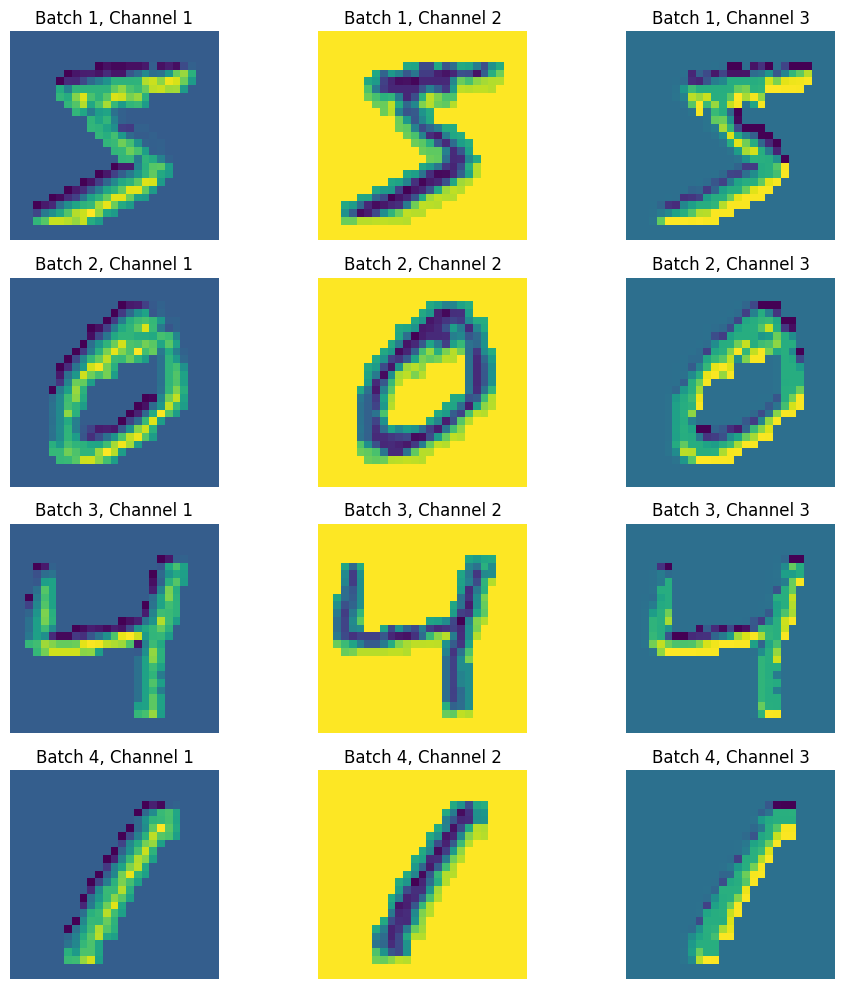

In [19]:
import torch
import matplotlib.pyplot as plt

# Generate a random tensor to simulate the model output
model_output = outputs  # Simulating a batch of 4 images with 3 channels and 27x27 size

# Set up the figure
fig, axes = plt.subplots(4, 3, figsize=(10, 10))

# Loop through the images in the batch and display them
for batch_idx in range(4):
    for channel_idx in range(3):
        ax = axes[batch_idx, channel_idx]
        ax.imshow(model_output[batch_idx, channel_idx].cpu().detach().numpy())
        ax.axis('off')  # Turn off axis
        ax.set_title(f"Batch {batch_idx+1}, Channel {channel_idx+1}")

# Adjust layout
plt.tight_layout()
plt.show()


In [20]:
from torcheval.metrics import MulticlassAccuracy
from torcheval.metrics.functional import multiclass_accuracy


In [18]:
model = QuanvolutionalCNN(model_type = 'classic').to(torch.device('cuda'))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
logging_steps = 100
from sklearn.metrics import accuracy_score

metric = MulticlassAccuracy()
losses = np.array([])
accs = np.array([])
global_step = 0
for epoch in range(10):
    
    for i, (images, labels) in enumerate(train_loader):
        
        images = images.unsqueeze(1).cuda()
        # print(images.size(), images.unsqueeze(1).size())
        optimizer.zero_grad()  # Reset gradients
        outputs = model(images).cpu()  # Forward pass
        # print(outputs, labels)
        loss = criterion(outputs, labels)  
        loss.backward()
        optimizer.step()
        
        # output
        acc = multiclass_accuracy(outputs, labels)
        
        metric.update(outputs, labels)
        losses = np.append(losses, loss.item())
        global_step += 1
        if global_step % logging_steps == 0:
            print("Epoch:", epoch+1, 
                "\tStep:", global_step, 
                # "\tAcc:", round(float(acc), 3), 
                "\tLoss:", round(loss.item(),3),
                "\tMean Loss:", round(float(losses[-30:].mean()), 3),
                "\tMean Acc:", round(float(metric.compute()), 3)
                )
        # break

        # losses = np.append(losses, loss.item())

        # print("After update:", model.quanv.q_params.grad)
        # print(f"Epoch {epoch + 1}, Loss: {loss.item()}")


Epoch: 1 	Step: 100 	Loss: 2.081 	Mean Loss: 2.075 	Mean Acc: 0.257
Epoch: 1 	Step: 200 	Loss: 2.204 	Mean Loss: 2.095 	Mean Acc: 0.335
Epoch: 1 	Step: 300 	Loss: 1.914 	Mean Loss: 2.019 	Mean Acc: 0.376
Epoch: 1 	Step: 400 	Loss: 2.128 	Mean Loss: 2.054 	Mean Acc: 0.4
Epoch: 1 	Step: 500 	Loss: 2.419 	Mean Loss: 1.935 	Mean Acc: 0.431
Epoch: 1 	Step: 600 	Loss: 1.907 	Mean Loss: 1.921 	Mean Acc: 0.457
Epoch: 1 	Step: 700 	Loss: 1.914 	Mean Loss: 1.876 	Mean Acc: 0.475
Epoch: 1 	Step: 800 	Loss: 2.025 	Mean Loss: 1.873 	Mean Acc: 0.49


KeyboardInterrupt: 

In [24]:
model = QuanvolutionalCNN(model_type = 'quantum').cuda()

print(model)

11
4
14
QuanvolutionalCNN(
  (conv_block): Sequential(
    (0): QuanvolutionLayerTest(
      (kernel_circuits): <Quantum Torch Layer: func=circuit>
    )
    (1): ReLU()
    (2): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.5, inplace=False)
    (5): QuanvolutionLayerTest(
      (kernel_circuits): <Quantum Torch Layer: func=circuit>
    )
    (6): ReLU()
    (7): QuanvolutionLayerTest(
      (kernel_circuits): <Quantum Torch Layer: func=circuit>
    )
    (8): ReLU()
    (9): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.3, inplace=False)
  )
  (fc): Sequential(
    (0): DynLinear()
    (1): Dropout(p=0.3, inplace=False)
    (2): ReLU()
    (3): DynLinear()
  )
  (softmax): Softmax(dim=1)
)


In [25]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
logging_steps = 1
# from sklearn.metrics import accuracy_score

metric = MulticlassAccuracy()
losses = np.array([])
accs = np.array([])
global_step = 0
for epoch in range(10):
    
    for i, (images, labels) in enumerate(train_loader):
        
        images = images.unsqueeze(1).cuda()
        # print(images.size(), images.unsqueeze(1).size())
        optimizer.zero_grad()  # Reset gradients
        outputs = model(images).cpu()  # Forward pass
        print(outputs, labels)
        loss = criterion(outputs, labels)  
        loss.backward()
        optimizer.step()
        
        # output
        acc = multiclass_accuracy(outputs, labels)
        
        metric.update(outputs, labels)
        losses = np.append(losses, loss.item())
        global_step += 1
        if global_step % logging_steps == 0:
            print("Epoch:", epoch+1, 
                "\tStep:", global_step, 
                # "\tAcc:", round(float(acc), 3), 
                "\tLoss:", round(loss.item(),3),
                "\tMean Loss:", round(float(losses[-30:].mean()), 3),
                "\tMean Acc:", round(float(metric.compute()), 3)
                )
        # break

27 27
CUR BATCH: 0
CUR BATCH: 1
12 12
CUR BATCH: 0
CUR BATCH: 1
11 11
CUR BATCH: 0
CUR BATCH: 1
tensor([[0.1021, 0.0793, 0.0883, 0.2892, 0.0807, 0.1475, 0.0489, 0.0340, 0.0818,
         0.0482],
        [0.1134, 0.0806, 0.0109, 0.2352, 0.1079, 0.0392, 0.1046, 0.1274, 0.1212,
         0.0597]], grad_fn=<ToCopyBackward0>) tensor([5, 0])
Epoch: 1 	Step: 1 	Loss: 2.274 	Mean Loss: 2.274 	Mean Acc: 0.0
27 27
CUR BATCH: 0
CUR BATCH: 1
12 12
CUR BATCH: 0
CUR BATCH: 1
11 11
CUR BATCH: 0
CUR BATCH: 1


KeyboardInterrupt: 

In [30]:
!pip install pennylane custatevec-cu12 pennylane-lightning[gpu] --force-reinstall

  Using cached PennyLane-0.39.0-py3-none-any.whl.metadata (9.2 kB)
  Using cached custatevec_cu12-1.7.0-py3-none-manylinux2014_x86_64.whl.metadata (2.2 kB)
  Using cached PennyLane_Lightning-0.39.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (26 kB)
  Using cached numpy-2.0.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached scipy-1.14.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached rustworkx-0.15.1-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.9 kB)
  Using cached autograd-1.7.0-py3-none-any.whl.metadata (7.5 kB)
  Using cached toml-0.10.2-py2.py3-none-any.whl.metadata (7.1 kB)
  Using cached appdirs-1.4.4-py2.py3-none-any.whl.metadata (9.0 kB)
  Using cached autoray-0.7.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached cachetools-5.5.0-py3-none-any.whl.metadata (5.3 kB)
  Using cached requests-2.32.3-py3-non

In [2]:
import pennylane as qml
dev = qml.device('lightning.gpu', wires = 4)

ModuleNotFoundError: No module named 'pennylane.devices.capabilities'

In [45]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14,4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for i in range(4):
      cir = circuit1
      for j in range(0, 28, 2):
          for k in range(0, 28, 2):
              # Process a squared 2x2 region of the image with a quantum circuit
              # print(j, k )
              q_results = cir(
                  [
                      image[0,j, k],
                      image[0,j, k + 1],
                      image[0,j + 1, k],
                      image[0,j + 1, k + 1]
                  ]
              )
              # Assign expectation values to different channels of the output pixel (j/2, k/2)
              # print(q_results)
                  # out[j // 2, k // 2, c] = q_results[c]
              for c in range(4):
                # print(out[i, j // 2, k // 2], q_results[c])
                out[j // 2, k // 2,c] += q_results[c].float().numpy()
              # out[j // 2, k // 2, i] /= 4
    return out

# Quantum pre-processing of the dataset

Since we are not going to train the quantum convolution layer, it is
more efficient to apply it as a \"pre-processing\" layer to all the
images of our dataset. Later an entirely classical model will be
directly trained and tested on the pre-processed dataset, avoiding
unnecessary repetitions of quantum computations.

The pre-processed images will be saved in the folder `SAVE_PATH`. Once
saved, they can be directly loaded by setting `PREPROCESS = False`,
otherwise the quantum convolution is evaluated at each run of the code.



In [41]:
import os
os.environ["OMP_NUM_THREADS"] = "16"  # Replace 4 with your desired number of threads


In [ ]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, (img, _) in enumerate(train_loader):
        # print(img.size())
        if idx >=5: break
        print("\r{}/{}".format(idx + 1, n_train), end = '')
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("\r{}/{}".format(idx + 1, n_test), end = '')
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # # Save pre-processed images
    # np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    # np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# # Load pre-processed images
# q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
# q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:
1/50

/home/paultran27/miniconda3/envs/pnl/lib/python3.11/site-packages/pennylane/math/utils.py:228: UserWarning: Contains tensors of types {'autograd', 'torch'}; dispatch will prioritize TensorFlow, PyTorch, and Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


5/50
Quantum pre-processing of test images:


NameError: name 'test_images' is not defined

Let us visualize the effect of the quantum convolution layer on a batch
of samples:


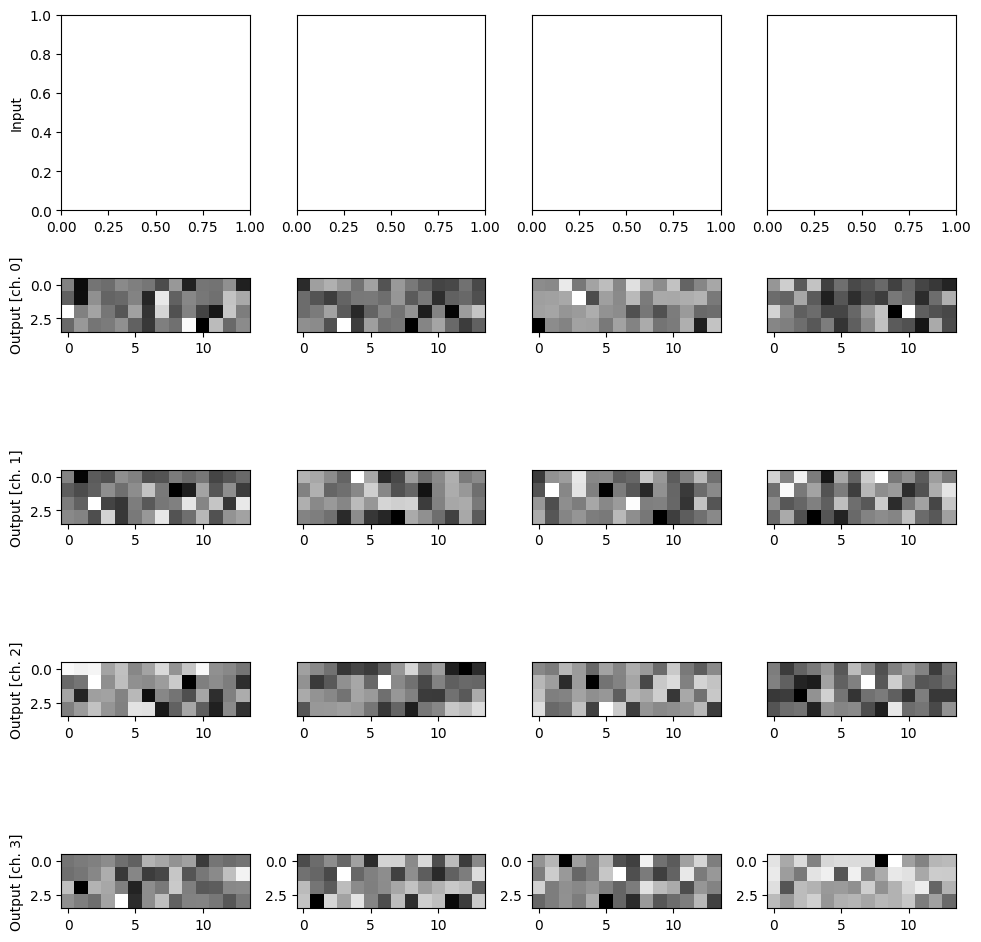

In [44]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    # axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

Below each input image, the $4$ output channels generated by the quantum
convolution are visualized in gray scale.

One can clearly notice the downsampling of the resolution and some local
distortion introduced by the quantum kernel. On the other hand the
global shape of the image is preserved, as expected for a convolution
layer.


# Hybrid quantum-classical model

After the application of the quantum convolution layer we feed the
resulting features into a classical neural network that will be trained
to classify the $10$ different digits of the MNIST dataset.

We use a very simple model: just a fully connected layer with 10 output
nodes with a final *softmax* activation function.

The model is compiled with a *stochastic-gradient-descent* optimizer,
and a *cross-entropy* loss function.


In [100]:
train_images.shape

NameError: name 'train_images' is not defined

In [50]:

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

def ClassicModel():
    """Initializes and returns a custom Keras CNN model ready to be trained on MNIST."""
    model = keras.models.Sequential([
        # First Convolutional layer
        layers.Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

def QuanvModel():
    """Initializes and returns a custom Keras CNN model ready to be trained on MNIST."""
    model = keras.models.Sequential([
        # First Convolutional layer
        layers.Conv2D(32, (3, 3), activation="relu", input_shape=(14, 14, 4)),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model



# Training

We first initialize an instance of the model, then we train and validate
it with the dataset that has been already pre-processed by a quantum
convolution.


In [51]:
q_model = QuanvModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 - 3s - 1s/step - accuracy: 0.0000e+00 - loss: 2.8372 - val_accuracy: 0.0000e+00 - val_loss: 2.7045
Epoch 2/30
2/2 - 0s - 30ms/step - accuracy: 0.8000 - loss: 1.2979 - val_accuracy: 0.0000e+00 - val_loss: 3.3358
Epoch 3/30
2/2 - 0s - 24ms/step - accuracy: 0.6000 - loss: 0.9884 - val_accuracy: 0.0000e+00 - val_loss: 3.7362
Epoch 4/30
2/2 - 0s - 27ms/step - accuracy: 0.6000 - loss: 0.8411 - val_accuracy: 0.0000e+00 - val_loss: 3.6965
Epoch 5/30
2/2 - 0s - 36ms/step - accuracy: 1.0000 - loss: 0.5623 - val_accuracy: 0.0000e+00 - val_loss: 3.4626
Epoch 6/30
2/2 - 0s - 24ms/step - accuracy: 1.0000 - loss: 0.3246 - val_accuracy: 0.0000e+00 - val_loss: 3.2518
Epoch 7/30
2/2 - 0s - 29ms/step - accuracy: 1.0000 - loss: 0.1819 - val_accuracy: 0.2000 - val_loss: 3.1162
Epoch 8/30
2/2 - 0s - 34ms/step - accuracy: 1.0000 - loss: 0.0998 - val_accuracy: 0.4000 - val_loss: 3.0552
Epoch 9/30
2/2 - 0s - 22ms/step - accuracy: 1.0000 - loss: 0.0574 - val_accuracy: 0.4000 - val_loss: 3.0533
Epoch 10/30
2

In order to compare the results achievable with and without the quantum
convolution layer, we initialize also a \"classical\" instance of the
model that will be directly trained and validated with the raw MNIST
images (i.e., without quantum pre-processing).


In [45]:
c_model = ClassicModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
2/2 - 5s - 2s/step - accuracy: 0.0000e+00 - loss: 2.3735 - val_accuracy: 0.4000 - val_loss: 2.1891
Epoch 2/30
2/2 - 0s - 23ms/step - accuracy: 1.0000 - loss: 1.8873 - val_accuracy: 0.4000 - val_loss: 2.1258
Epoch 3/30
2/2 - 0s - 21ms/step - accuracy: 1.0000 - loss: 1.5827 - val_accuracy: 0.4000 - val_loss: 2.0856
Epoch 4/30
2/2 - 0s - 21ms/step - accuracy: 1.0000 - loss: 1.2649 - val_accuracy: 0.4000 - val_loss: 2.0636
Epoch 5/30
2/2 - 0s - 21ms/step - accuracy: 1.0000 - loss: 0.9371 - val_accuracy: 0.4000 - val_loss: 2.0659
Epoch 6/30
2/2 - 0s - 22ms/step - accuracy: 1.0000 - loss: 0.6406 - val_accuracy: 0.4000 - val_loss: 2.0890
Epoch 7/30
2/2 - 0s - 37ms/step - accuracy: 1.0000 - loss: 0.4030 - val_accuracy: 0.4000 - val_loss: 2.1315
Epoch 8/30
2/2 - 0s - 22ms/step - accuracy: 1.0000 - loss: 0.2404 - val_accuracy: 0.4000 - val_loss: 2.1862
Epoch 9/30
2/2 - 0s - 21ms/step - accuracy: 1.0000 - loss: 0.1377 - val_accuracy: 0.4000 - val_loss: 2.2471
Epoch 10/30
2/2 - 0s - 21m

# Results

We can finally plot the test accuracy and the test loss with respect to
the number of training epochs.


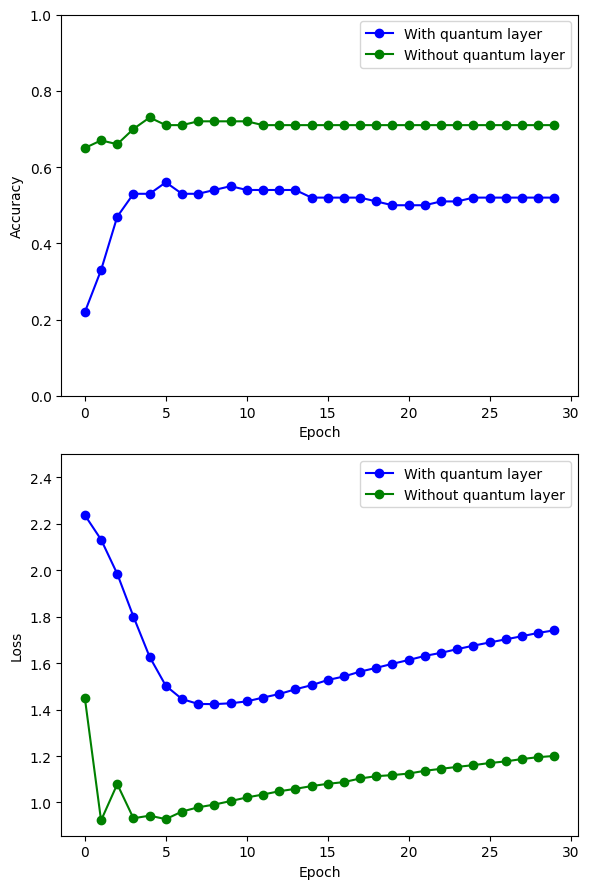

In [25]:
import matplotlib.pyplot as plt

# plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

# References

1.  Maxwell Henderson, Samriddhi Shakya, Shashindra Pradhan, Tristan
    Cook. \"Quanvolutional Neural Networks: Powering Image Recognition
    with Quantum Circuits.\"
    [arXiv:1904.04767](https://arxiv.org/abs/1904.04767), 2019.

# About the author
